## Compare location data to schedule

## Imports

In [1]:
import warnings
from datetime import datetime
from pathlib import Path

import gtfs_kit as gk
import pandas as pd
import seaborn as sns
from google.transit.gtfs_realtime_pb2 import FeedMessage

## General settings

In [2]:
pb2_path = Path("../data")
sched_path = "../data/itm_south_east_gtfs.zip"

## Load pb2 data

In [3]:
trips = []
for f in sorted(pb2_path.glob("*.pb2")):
    msg = FeedMessage()
    msg.ParseFromString(f.read_bytes())
    for t in msg.entity:
        trips.append(t)

In [4]:
rows = [
    {
        "id": t.id,
        "trip_id": t.vehicle.trip.trip_id,
        "route_id": t.vehicle.trip.route_id,
        "start_time": t.vehicle.trip.start_time,
        "start_date": t.vehicle.trip.start_date,
        "latitude": t.vehicle.position.latitude,
        "longitude": t.vehicle.position.longitude,
        "current_stop": t.vehicle.current_stop_sequence,
        "current_status": t.vehicle.current_status,
        "timestamp": datetime.utcfromtimestamp(t.vehicle.timestamp),
        "vehicle": t.vehicle.vehicle.id,
    }
    for t in trips
]
df = pd.DataFrame(rows).drop_duplicates()
df.timestamp = df.timestamp.dt.tz_localize("UTC")
df.head(2)

,id,trip_id,route_id,start_time,start_date,latitude,longitude,current_stop,current_status,timestamp,vehicle
0,13763630073698663407,VJ9319dc35a520096b9b1e6abe863fd465be3f5e80,50065,16:10:00,20221015,51.729813,-1.212313,13,2,2022-10-15 16:37:46+00:00,300
1,15671302897479048672,VJa30a7b0edb53edbd19908a14241d6f9f8d43fd1a,50065,16:25:00,20221015,51.731411,-1.214491,14,2,2022-10-15 16:37:43+00:00,311
2,8931724906858233862,VJbf1af309850819f0c13270b1c82a48b16c1448bf,3815,16:34:00,20221015,51.753353,-1.269630,0,1,2022-10-15 16:37:37+00:00,SCOX-10439
3,9393660296727820281,VJ4453880e00c6b8699902fa03cd32d0b0e4f5bb82,3815,15:28:00,20221015,51.753132,-1.269510,34,2,2022-10-15 16:37:29+00:00,SCOX-10670
4,2588383118819005104,VJ86c3f449922868daf9a499258fafb398d30fa050,4824,16:00:00,20221015,51.743992,-1.201763,23,2,2022-10-15 16:37:36+00:00,SCOX-10679


In [5]:
unq_cols = ["route_id", "trip_id", "current_stop"]
actual = (
    df[unq_cols]
    .drop_duplicates()
    .join(
        df.groupby(unq_cols).timestamp.last().shift(1).rename("arrival_actual"),
        on=unq_cols,
    )
    .join(
        df.groupby(unq_cols).timestamp.first().shift(-1).rename("departure_actual"),
        on=unq_cols,
    )
)
actual.arrival_actual = actual.arrival_actual.fillna(actual.departure_actual)
actual.departure_actual = actual.departure_actual.fillna(actual.arrival_actual)
actual.head(2)

,route_id,trip_id,current_stop,arrival_actual,departure_actual
0,50065,VJ9319dc35a520096b9b1e6abe863fd465be3f5e80,13,2022-10-15 17:17:49+00:00,2022-10-15 16:38:09+00:00
1,50065,VJa30a7b0edb53edbd19908a14241d6f9f8d43fd1a,14,2022-10-15 18:18:57+00:00,2022-10-15 16:40:43+00:00
2,3815,VJbf1af309850819f0c13270b1c82a48b16c1448bf,0,2022-10-15 17:37:09+00:00,2022-10-15 16:39:38+00:00
3,3815,VJ4453880e00c6b8699902fa03cd32d0b0e4f5bb82,34,2022-10-15 18:15:49+00:00,2022-10-15 16:37:43+00:00
4,4824,VJ86c3f449922868daf9a499258fafb398d30fa050,23,2022-10-15 16:55:16+00:00,2022-10-15 16:38:58+00:00


## Load schedule feed

In [6]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fd = gk.read_feed(sched_path, dist_units="mi")

## Join and compare times

In [7]:
def fix_dt(col):
    def fn(row):
        return row.arrival_actual.strftime("%Y-%m-%d") + "T" + row[col]
    return fn

In [8]:
def to_utc(se):
    return se.dt.tz_localize("Europe/London").dt.tz_convert("UTC")

In [9]:
keep_cols = [
    "route_id",
    "trip_id",
    "stop_id",
    "stop_sequence",
    "arrival_time",
    "arrival_actual",
    "departure_time",
    "departure_actual",
]
comp = fd.stop_times.merge(
    actual, left_on=["trip_id", "stop_sequence"], right_on=["trip_id", "current_stop"]
)[keep_cols]
comp = comp.assign(
    arrival_time=pd.to_datetime(comp.apply(fix_dt("arrival_time"), axis=1)).pipe(
        to_utc
    ),
    departure_time=pd.to_datetime(comp.apply(fix_dt("departure_time"), axis=1)).pipe(
        to_utc
    ),
)
comp = comp.assign(
    arrival_diff=(comp.arrival_actual - comp.arrival_time).astype("timedelta64[s]"),
    departure_diff=(comp.departure_actual - comp.departure_time).astype(
        "timedelta64[s]"
    ),
)
comp.head()

,route_id,trip_id,stop_id,stop_sequence,arrival_time,arrival_actual,departure_time,departure_actual,arrival_diff,departure_diff
0,50065,VJ967a265ecfa77f299469a336b6d896cc97ee755e,340001244OPS,2,2022-10-15 18:12:00+00:00,2022-10-15 16:48:31+00:00,2022-10-15 18:12:00+00:00,2022-10-15 16:37:43+00:00,-5009.0,-5657.0
1,50065,VJ843caff8938f113107e2ff80c66afd2f80ff2f9d,340001989S2,0,2022-10-15 18:12:00+00:00,2022-10-15 18:00:38+00:00,2022-10-15 18:12:00+00:00,2022-10-15 18:12:14+00:00,-682.0,14.0
2,50065,VJ843caff8938f113107e2ff80c66afd2f80ff2f9d,340002074G5,1,2022-10-15 18:15:00+00:00,2022-10-15 18:11:51+00:00,2022-10-15 18:15:00+00:00,2022-10-15 18:13:09+00:00,-189.0,-111.0
3,50065,VJ843caff8938f113107e2ff80c66afd2f80ff2f9d,340001992K1,2,2022-10-15 18:17:00+00:00,2022-10-15 18:12:35+00:00,2022-10-15 18:17:00+00:00,2022-10-15 18:17:00+00:00,-265.0,0.0
4,50065,VJ843caff8938f113107e2ff80c66afd2f80ff2f9d,340001126TYN,3,2022-10-15 18:19:00+00:00,2022-10-15 18:16:48+00:00,2022-10-15 18:19:00+00:00,2022-10-15 16:37:47+00:00,-132.0,-6073.0


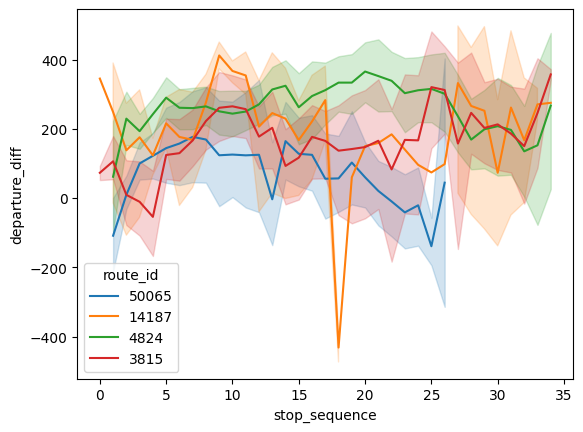

In [11]:
ax = sns.lineplot(
    comp.loc[
        (500 > comp.arrival_diff)
        & (500 > comp.departure_diff)
        & (-500 < comp.arrival_diff)
        & (-500 < comp.departure_diff)
    ],
    x="stop_sequence",
    y="departure_diff",
    hue="route_id",
    # legend=False,
)